# 0. required packages for h5py

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

14340


# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(External.Fitting_v4)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder': r'\\10.245.74.158\Chromatin_NAS_6\20201012-mouse_proB_IgH++',
             'save_folder': r'\\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++',
             'experiment_type': 'DNA',
             'num_threads': 24,
             'correction_folder': r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':250,
                     'max_num_seeds': 2000,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

In [4]:
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=3,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 81
- Number of field of views: 72
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201012-mouse_proB_IgH++\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ creating save folder: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++

### 2. Process image into candidate spots

In [6]:
reload(io_tools.load)
reload(spot_tools.fitting)
reload(correction_tools.chromatic)
reload(classes.batch_functions)

# process image into spots
id_list, spot_list = fov._process_image_to_spots('unique', 
                                                 #_parallel=False,
                                                 #_sel_ids=np.arange(41,44),
                                                 _load_common_reference=True,
                                                 _load_with_multiple=False,
                                                 _save_images=True,
                                                 _warp_images=False, 
                                                 _overwrite_drift=False,
                                                 _overwrite_image=False,
                                                 _overwrite_spot=True,
                                                 _verbose=True)

-- No folder selected, allow processing all 74 folders
-- checking unique, region:[326 324] in 0.325s.
-- checking unique, region:[329 327] in 0.015s.
-- checking unique, region:[332 330] in 0.013s.
-- checking unique, region:[335 333] in 0.012s.
-- checking unique, region:[339 337] in 0.010s.
-- checking unique, region:[342 340] in 0.011s.
-- checking unique, region:[345 343] in 0.009s.
-- checking unique, region:[348 346] in 0.007s.
-- checking unique, region:[351 349] in 0.000s.
-- checking unique, region:[354 352] in 0.016s.
-- checking unique, region:[357 355] in 0.011s.
-- checking unique, region:[360 358] in 0.000s.
-- checking unique, region:[363 361] in 0.022s.
-- checking unique, region:[366 364] in 0.010s.
-- checking unique, region:[369 367] in 0.010s.
-- checking unique, region:[372 370] in 0.010s.
-- checking unique, region:[375 373] in 0.010s.
-- checking unique, region:[379 376] in 0.009s.
-- checking unique, region:[382 380] in 0.010s.
-- checking unique, region:[388 3

# 3. Find chromosomes

## 3.1 load chromosome image

In [7]:
overwrite_chrom = True 
chrom_im = fov._load_chromosome_image(_type='forward', 
                                      _overwrite=overwrite_chrom)

-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201012-mouse_proB_IgH++\H0R0\Conv_zscan_03.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201012-mouse_proB_IgH++\H0R0\Conv_zscan_03.dax  in 8.266s
-- removing hot pixels for channels:['750'] in 7.097s
-- illumination correction for channels: 750, in 1.559s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 74.250s
-- finish correction in 113.078s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Conv_zscan_03.hdf5
++ base attributes saved:['chrom_im'] in 5.303s.


## 3.2 find candidate chromosomes

In [8]:
chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4,
                                                               _binary_per_th=99.75, 
                                                               _morphology_size=2,
                                                               _overwrite=overwrite_chrom)

-- adjust seed image with filter size=4
-- binarize image with threshold: 99.75%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.


E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 588 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 20 threads in 582.656s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.029s.


## 3.3 select among candidate chromosomes

In [9]:
chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.25,
                                                         _cand_spot_intensity_th=200,
                                                         _save=True, 
                                                         _overwrite=overwrite_chrom)

+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Conv_zscan_03.hdf5
++ finish loading unique in 0.184s. 

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])



- start select from 588 chromosomes with loss threshold=0.25
-- 588 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Conv_zscan_03.hdf5
++ base attributes saved:['chrom_coords'] in 0.078s.


### visualize chromosomes selections

<IPython.core.display.Javascript object>


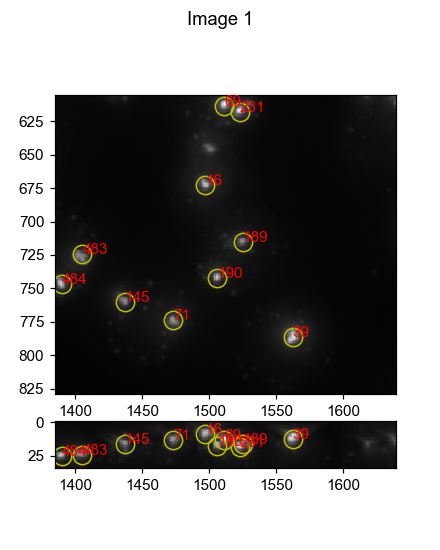

In [10]:
%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[np.flipud(_coord) for _coord in fov.chrom_coords],
              'class_ids':list(np.zeros(len(fov.chrom_coords),dtype=np.int)),
             }

visual_tools.imshow_mark_3d_v2([fov.chrom_im], 
                               given_dic=coord_dict,
                               save_file=None,
                               )

## select spots based on chromosomes

In [11]:
fov._load_from_file('unique')

+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Conv_zscan_03.hdf5


In [12]:
## assign spots to chromosomes
intensity_th = 200
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

kept_spots_list = []
for _spots in fov.unique_spots_list:
    kept_spots_list.append(_spots[_spots[:,0] > intensity_th])
# finalize candidate spots
cand_chr_spots_list = [[] for _ct in fov.chrom_coords]
for _spots in kept_spots_list:
    _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
    for _i, _cands in enumerate(_cands_list):
        cand_chr_spots_list[_i].append(_cands)
print(f"kept chromosomes: {len(fov.chrom_coords)}")

kept chromosomes: 588


In [13]:
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys

dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels
chrom_coords = fov.chrom_coords


# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
    
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

kept chromosomes: 586


### EM pick spots

+ iter:0
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 8.008s
--- collapse all regions into 1d.


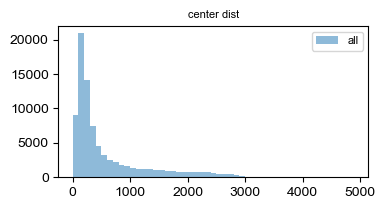

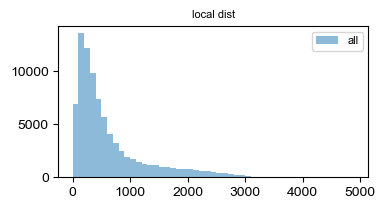

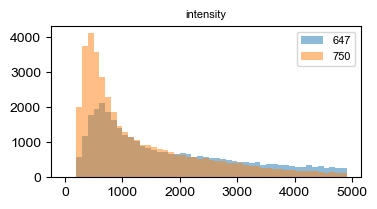

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 8.234s
-- region kept: 0.7846


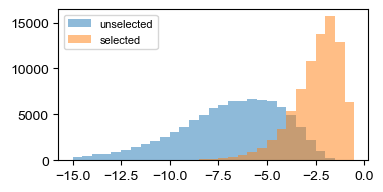

+ iter:1
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 7.433s
--- collapse all regions into 1d.


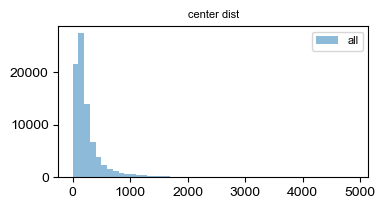

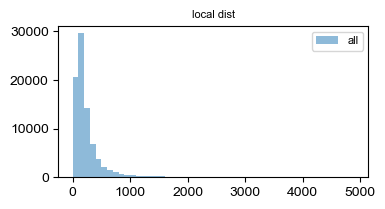

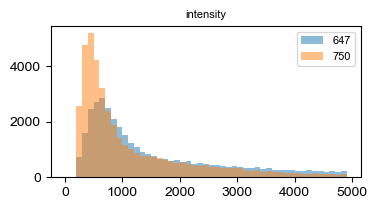

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 8.391s
-- region kept: 0.9506


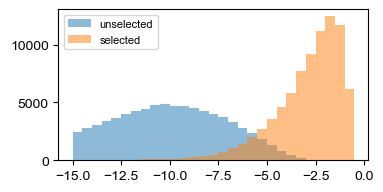

+ iter:2
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 7.592s
--- collapse all regions into 1d.


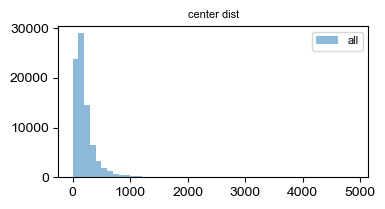

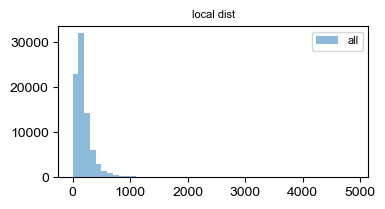

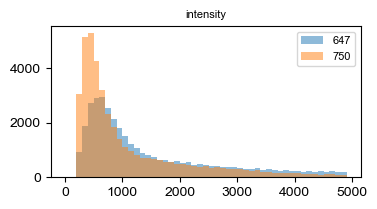

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 8.314s
-- region kept: 0.9872


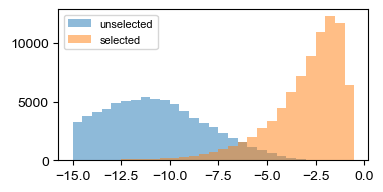

+ iter:3
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 7.595s
--- collapse all regions into 1d.


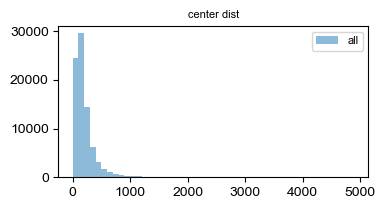

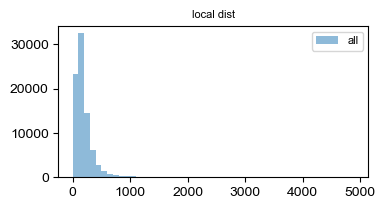

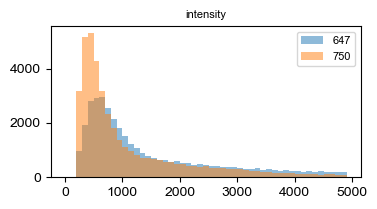

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 8.328s
-- region kept: 0.9956


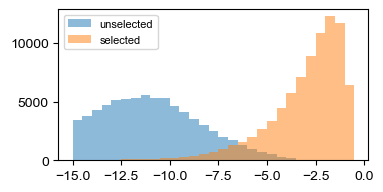

+ iter:4
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 7.643s
--- collapse all regions into 1d.


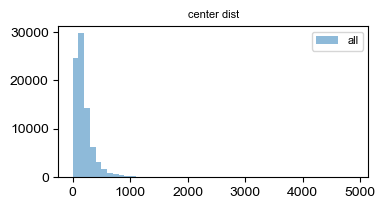

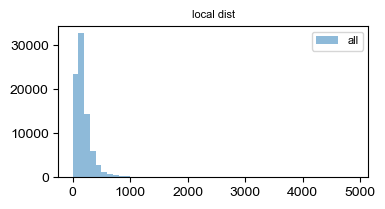

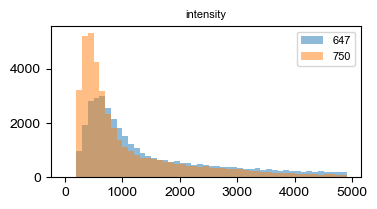

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 8.388s
-- region kept: 0.9980


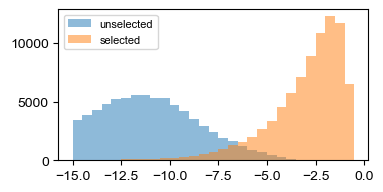

In [14]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 32
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15,0,0.5), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15,0,0.5), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

In [15]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -6.5
int_th = 300
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
#kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

0.10223367697594501


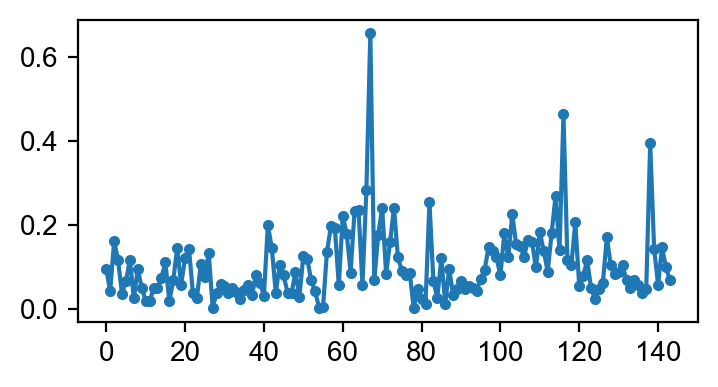

In [16]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

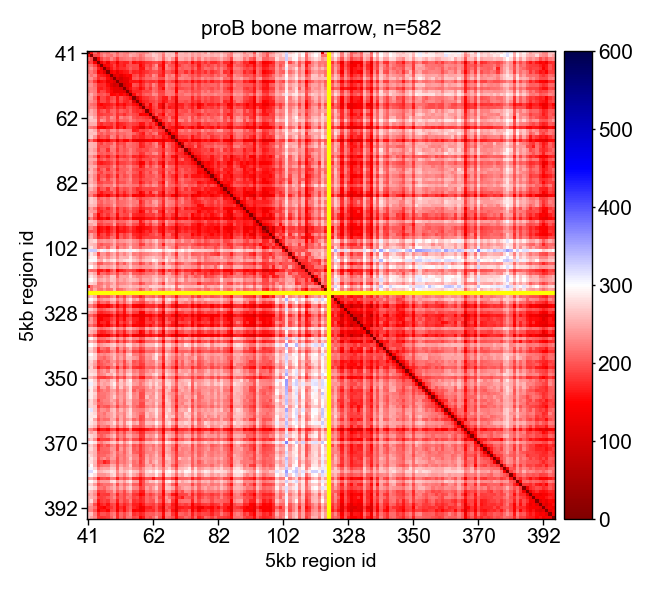

In [33]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

#kept_inds = np.where(loss_rates<0.5)[0] # plot good regions only
kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"proB bone marrow, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

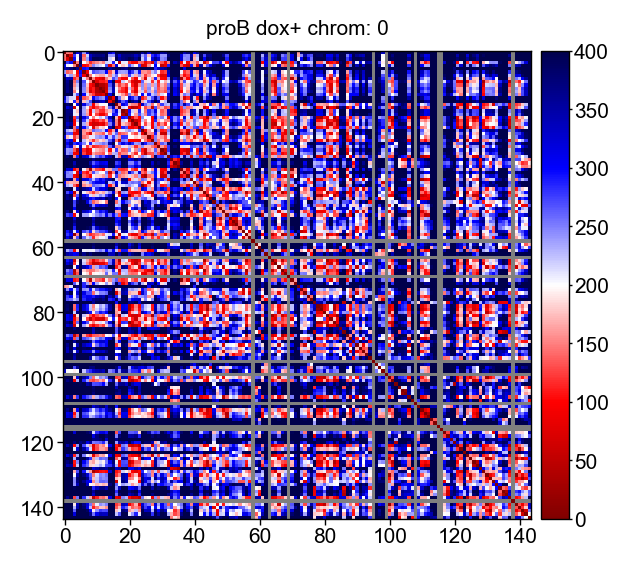

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000026CDD9AC128>


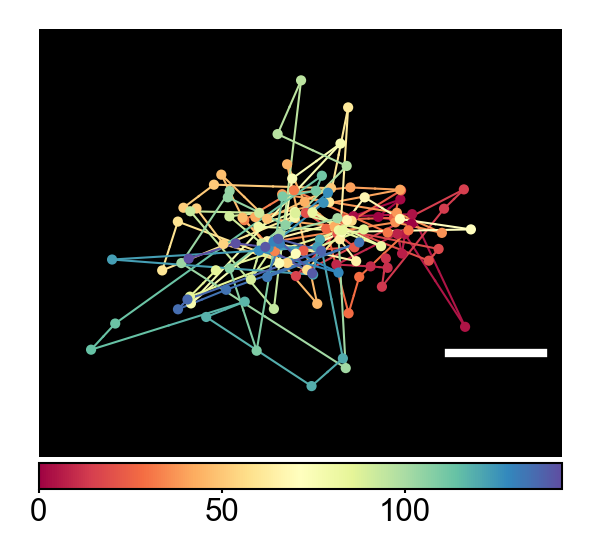

In [32]:
import matplotlib
import copy
%matplotlib inline
reload(matplotlib)
reload(plt)
reload(figure_tools.image)

chrom_id = 0

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool)

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,400],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"proB dox+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=100, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

## visualize spots by channel

[   9.14341847  576.87033399 1290.27111984]
-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000002AA73952E48>


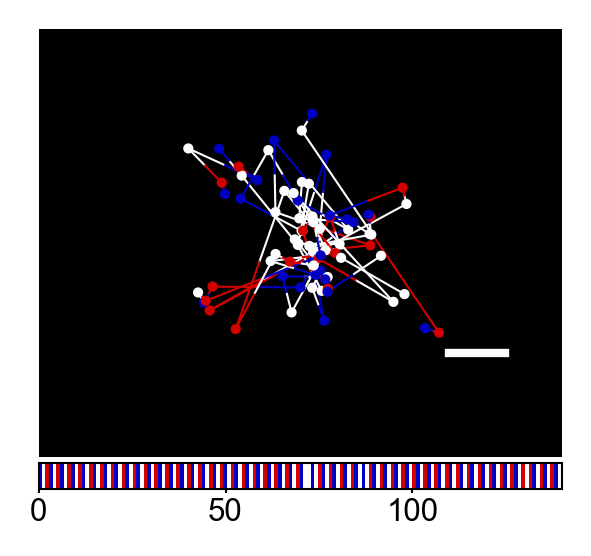

In [58]:
%matplotlib inline

import matplotlib
import copy
#chrom_id = 4

print(np.array(sel_chrom_coords)[kept_chr_ids][chrom_id])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

exist_channels = np.unique(dna_reg_channels)
channel_colors = []
for _ch in dna_reg_channels:
    channel_colors.append(sc_cmap((np.where(_ch==exist_channels)[0][0]+0.5)/len(exist_channels)))

    
ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        cmap=channel_colors,
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=300, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

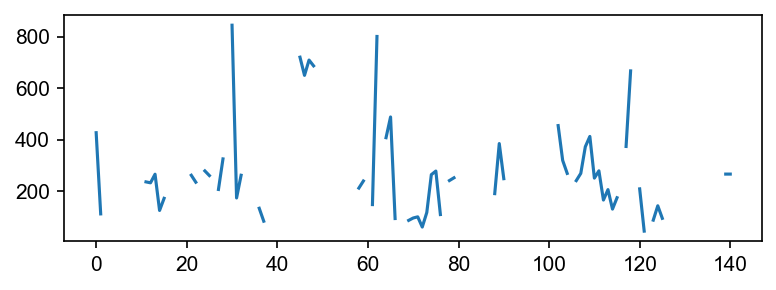

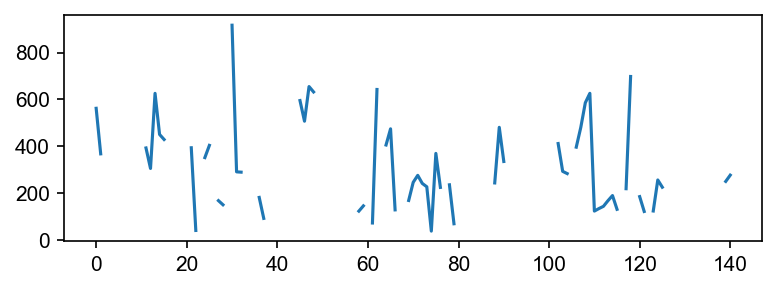

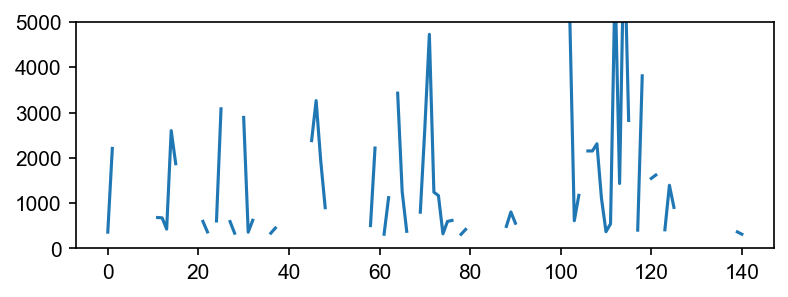

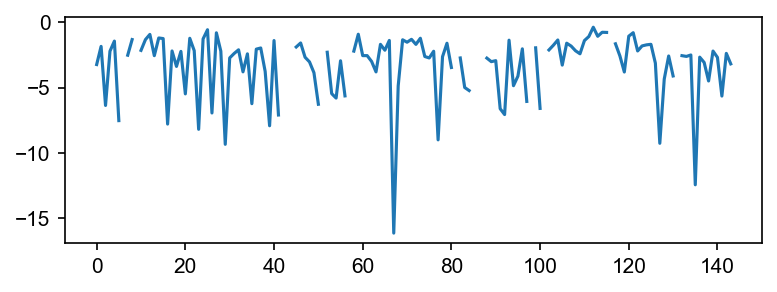

In [59]:
# calculate spot picking statistics
local_dists = spot_tools.picking.local_center_dists(final_dna_hzxys_list[chrom_id], dna_reg_ids, 
                                                    final_dna_hzxys_list[chrom_id], dna_reg_ids, neighbor_len=4)
plt.figure(figsize=(6,2), dpi=150)
plt.plot(local_dists)
plt.show()

# calculate spot picking statistics
reload(spot_tools.picking)
chr_ct_dists = spot_tools.picking.chromosome_center_dists(final_dna_hzxys_list[chrom_id], np.nanmean(final_dna_hzxys_list[chrom_id], axis=0), 
                                                         )
plt.figure(figsize=(6,2), dpi=150)
plt.plot(chr_ct_dists)
plt.show()

_intensities = final_dna_hzxys_list[chrom_id][:,0]
plt.figure(figsize=(6,2), dpi=150)
plt.plot(_intensities)
#plt.ylim([0, np.nanmax(final_dna_hzxys_list[chrom_id][:,0])])
plt.ylim([0,5000])
plt.show()

_scores = np.array(sel_dna_scores_list[-1])[kept_chr_ids][chrom_id]
plt.figure(figsize=(6,2), dpi=150)
plt.plot(_scores)

plt.show()

## visualize picked spots

Note: this section requires raw_spots for fov class, which is a new feature.
if you don't have this feature in older version, run "_process_image_to_spots" with "_overwrite_spots=True" will automatically append this feature.

In [ ]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    raw_spots_list = [_spots[_spots[:,0] > 0] for _spots in _grp['raw_spots'][:]]
    spots_list = [_spots[_spots[:,0] > 0] for _spots in _grp['spots'][:]]

In [46]:
from scipy.spatial.distance import cdist
picked_spot_inds_list = []
for _i, _id in enumerate(dna_reg_ids):
    _cand_hzxys = spots_list[_i][:,1:4] * fov.shared_parameters['distance_zxy']
    _dists = cdist(np.array(final_dna_hzxys_list)[:,_i,1:], _cand_hzxys)#, axis=1
    _matched_spot_inds = []
    for _ds in _dists:
        if np.sum(np.isnan(_ds)) < len(_ds) and np.nanmin(_ds) < 0.01:
            _matched_spot_inds.append(np.argmin(_ds))
        else:
            _matched_spot_inds.append(np.nan)
    # append
    picked_spot_inds_list.append(np.array(_matched_spot_inds))

NameError: name 'spots_list' is not defined

In [97]:
vis_inds = [0,1,2,3,4,5]
vis_ims, vis_ids, vis_spot_list, vis_raw_spot_list = [], [], [], []

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    
    for _ind in vis_inds:
        vis_ims.append(_grp['ims'][_ind])
        vis_ids.append(_grp['ids'][_ind])
        _picked_inds = picked_spot_inds_list[_ind]
        _picked_inds = np.array(_picked_inds[np.isnan(_picked_inds)==False], dtype=np.int)
        vis_spot_list.append(raw_spots_list[_ind][_picked_inds])

<IPython.core.display.Javascript object>


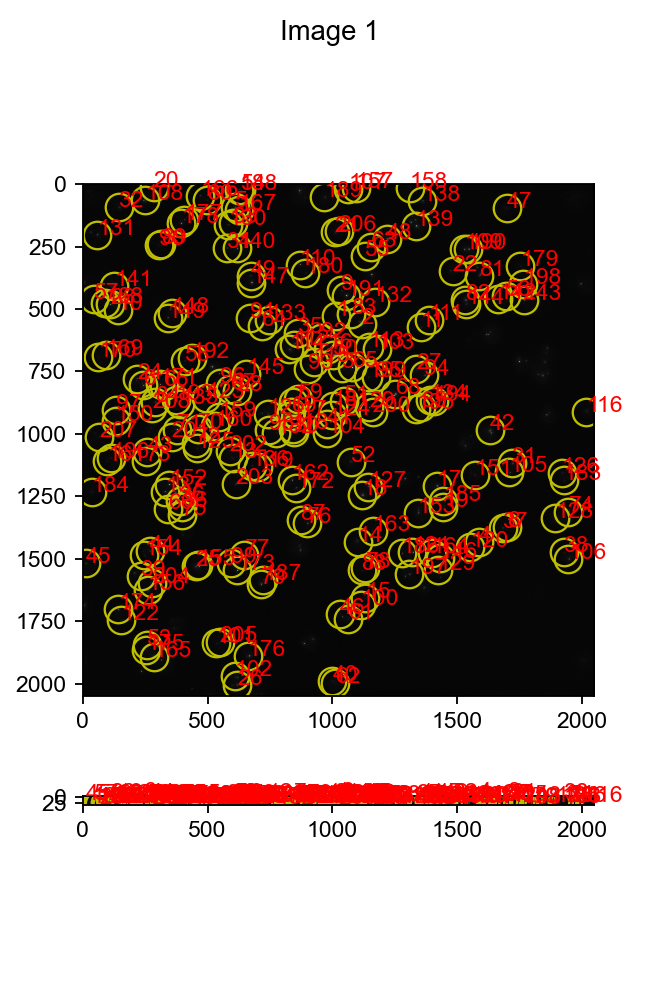

In [110]:
# visualize_all_chromosomes
%matplotlib notebook
%matplotlib notebook

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(vis_spot_list):
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _spots)
    coord_dict['class_ids'] += list(_i * np.ones(len(_spots),dtype=np.int))

fig=plt.figure(figsize=(4,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2(vis_ims, 
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,
                               )

### visualize picked spots for one chromosome

In [109]:
chrom_id = 4
vis_chrom_spots = []
vis_chrom_ids = []
for _i, _ind in enumerate(vis_inds):
    _picked_ind = picked_spot_inds_list[_ind][chrom_id]
    if np.isnan(_picked_ind) == False:
        _spot = raw_spots_list[_ind][int(_picked_ind)]
        vis_chrom_spots.append(_spot)
        vis_chrom_ids.append(_i)

<IPython.core.display.Javascript object>


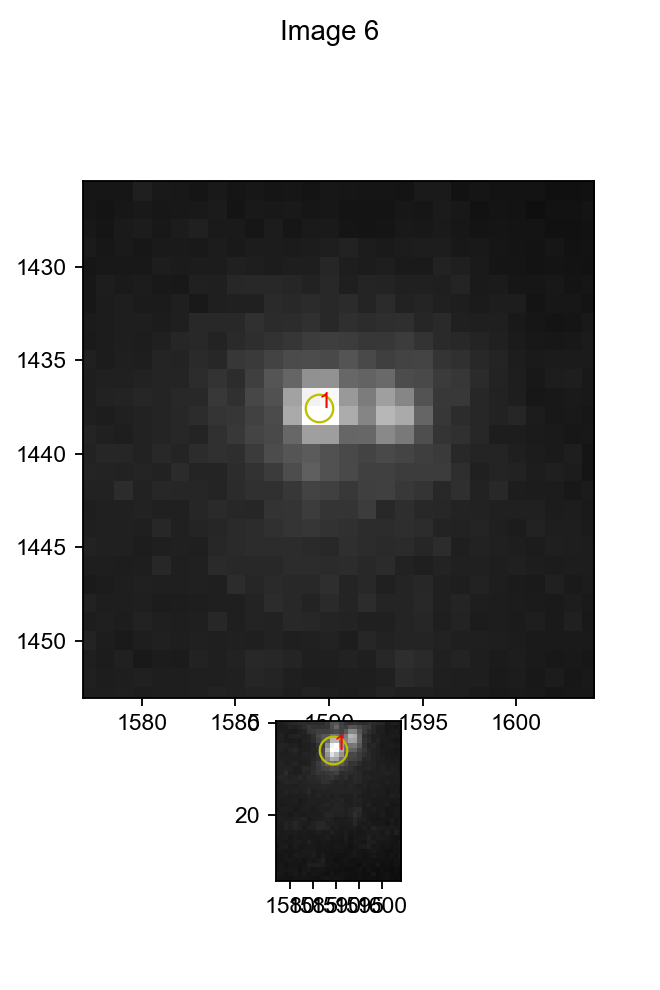

In [111]:
# visualize one chromosome
%matplotlib notebook
%matplotlib notebook
int_th = 300

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
coord_dict['coords'] = [np.flipud(_spot[1:4]) for _spot in vis_chrom_spots]
coord_dict['class_ids'] =  vis_chrom_ids

fig=plt.figure(figsize=(4,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2(vis_ims, 
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,
                               )

## visualize all fitted spots

In [91]:
cand_chr_spots_list[0][1].mean(0)

array([ 2.7823398e+02,  3.6345139e+00,  2.4295246e+01,  1.0203707e+03,
        6.2871539e+02,  2.5193291e+00,  3.3943014e+00,  1.8683887e+00,
        0.0000000e+00, -7.9286888e-02,  4.2638550e+01], dtype=float32)

In [15]:
vis_inds = [0,1,2]
vis_ims, vis_ids, vis_spot_list, vis_raw_spot_list = [], [], [], []
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _raw_spot_list = [_spots[_spots[:,0] > 0] for _spots in _grp['raw_spots'][:]]
    _spot_list = [_spots[_spots[:,0] > 0] for _spots in _grp['spots'][:]]
    
    for _ind in vis_inds:
        vis_ims.append(_grp['ims'][_ind])
        vis_ids.append(_grp['ids'][_ind])
        vis_spot_list.append(_spot_list[_ind])
        vis_raw_spot_list.append(_raw_spot_list[_ind])

In [22]:
# trace back selected spots
_chrom_id = 1
final_dna_hzxys_list[_chrom_id]

NameError: name 'final_dna_hzxys_list' is not defined

<IPython.core.display.Javascript object>


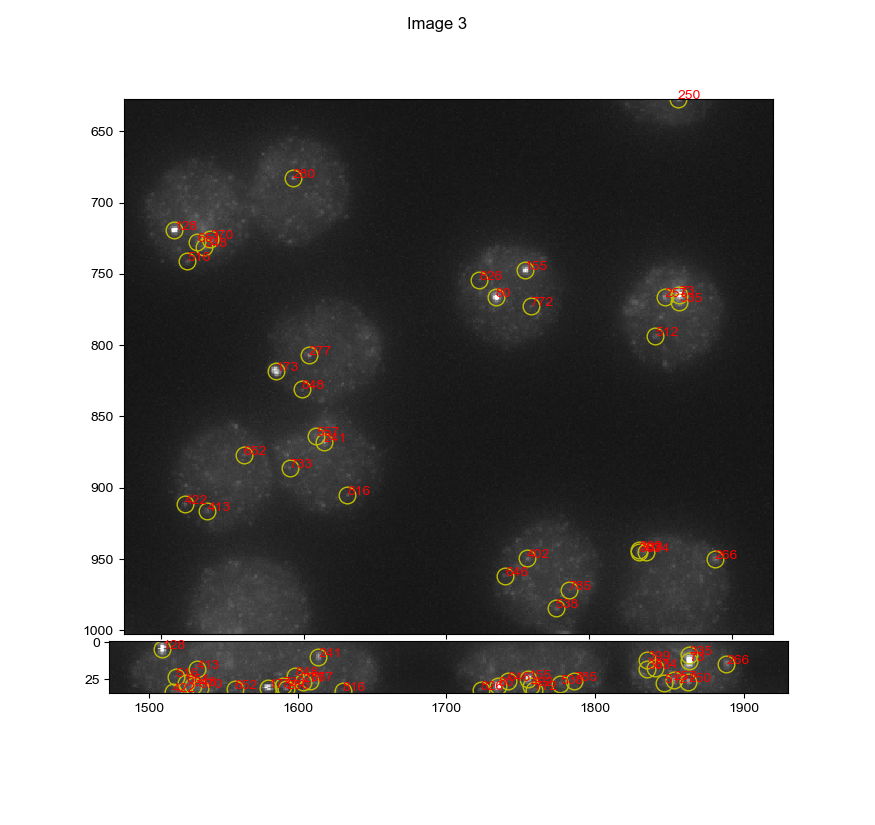

In [21]:
%matplotlib notebook
%matplotlib notebook
int_th = 300

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(vis_raw_spot_list):
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _spots[_spots[:,0] > int_th])
    coord_dict['class_ids'] += list(_i * np.ones(len(_spots[_spots[:,0] > int_th]),dtype=np.int))
    

visual_tools.imshow_mark_3d_v2(vis_ims, 
                               given_dic=coord_dict,
                               save_file=None,
                               )


<IPython.core.display.Javascript object>


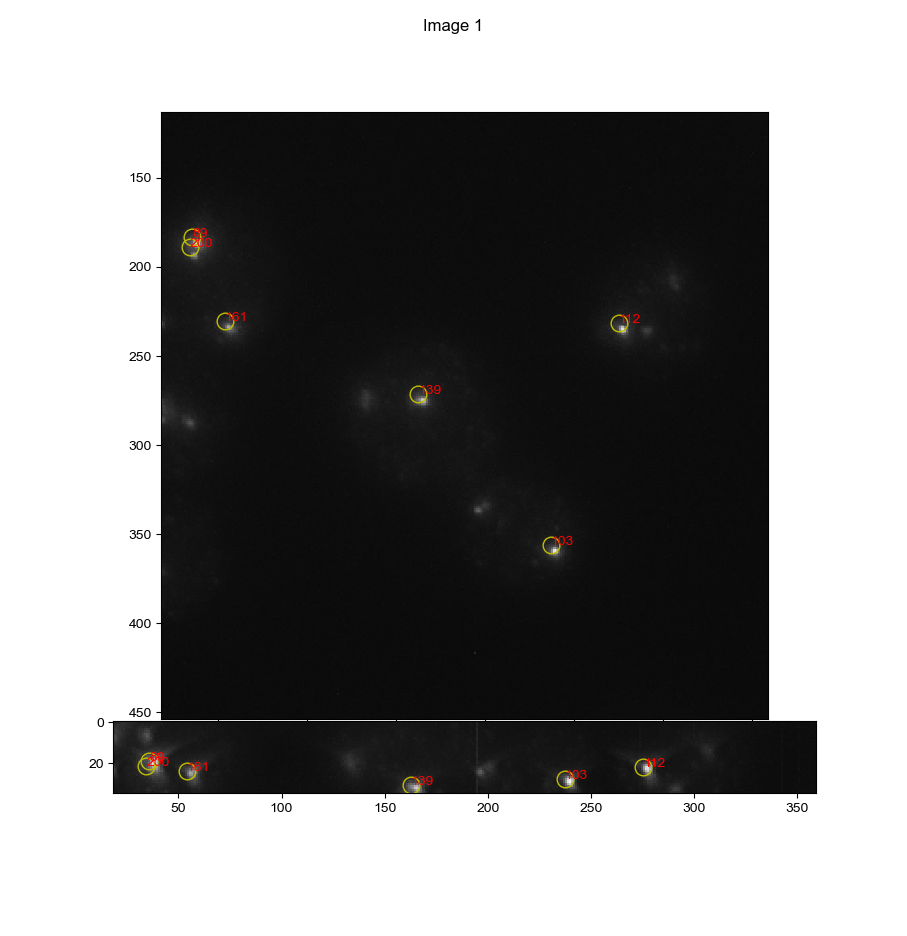

In [9]:
%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(sel_spot_list):
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _spots[:200])
    coord_dict['class_ids'] += list(_i * np.ones(len(_spots[:200]),dtype=np.int))
    

visual_tools.imshow_mark_3d_v2(sel_ims, 
                               given_dic=coord_dict,
                               save_file=None,
                               )